# TEST 0

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from config import *
from common import *
display.clear_output()

In [3]:
from affwild2_challenge.basic_emotion.losses1 import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion.metrics import expr_score, f1_score, concordance_cc2

from affwild2_challenge.basic_emotion.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name
from affwild2_challenge.basic_emotion.dataload_expr_image import ExprImageBalancedDataLoader
from affwild2_challenge.basic_emotion.datagen_expr_image  import DataGenerator

from affwild2_challenge.basic_emotion.dataaug  import train_aug, valid_aug
from affwild2_challenge.basic_emotion.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input

from affwild2_challenge.basic_emotion.models.models_expr_frames import EXP_FRAMES_V0, EXP_VA_FRAMES_V0
from affwild2_challenge.basic_emotion.models.model_vggface2_ft import VGGFace2_AffWild2_V0

## 1. Setup Environments

In [4]:
params = {}
params["results_dir"] = os.path.join(sub_dir, "results", "t24")
params["db_file"] = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_frames.h5")
params["db_root"] = os.path.join(dataset_dir, "AffWild2/data/cropped")
params["batch_size"] = 256
params["gpus"] = ["0", "1"]
params["weights_path"] = os.path.join(sub_dir, "weights", "t24_affwild2_expr_image_vggface2_resnet50_ft_01_weights_200213214417_epoch-343_val_loss-0.54_val_acc-0.83.h5")
# params["model_base_path"] = os.path.join(sub_dir, "weights", "rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5")

params["debug"] = False
params["run_train"] = True
params["run_valid"] = True
params["run_test"] = True

params["use_parallel_model"] = True
params["val_train"] = True
params["val_valid"] = True
params["max_queue_size"] = 16
params["workers"] = 8
params["use_multiprocessing"] = False

print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

if os.path.exists(params["results_dir"]) == False: os.makedirs(params["results_dir"])

parameters: 
+ results_dir: /mnt/dntai/projects/emotion/AffWild2Prj/submit/results/t24
+ db_file: /mnt/dntai/projects/emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames.h5
+ db_root: /mnt/dntai/projects/emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
+ batch_size: 256
+ gpus: ['0', '1']
+ weights_path: /mnt/dntai/projects/emotion/AffWild2Prj/submit/weights/t24_affwild2_expr_image_vggface2_resnet50_ft_01_weights_200213214417_epoch-343_val_loss-0.54_val_acc-0.83.h5
+ debug: False
+ run_train: True
+ run_valid: True
+ run_test: True
+ use_parallel_model: True
+ val_train: True
+ val_valid: True
+ max_queue_size: 16
+ workers: 8
+ use_multiprocessing: False


In [5]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  0,1
+ Keras backend:  tensorflow


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5

TensorFlow Version: 1.15.0
Default GPU Device: /device:GPU:0


## 2. Setup Data

In [6]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)
ds.load_scheme_emotion()

dataset_info: 
+ db_file: /mnt/dntai/projects/emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames.h5
+ db_root: /mnt/dntai/projects/emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
Loading Scheme Emotion: 
 + Loading train: 251
 + Loading valid: 69
 + Loading test: 223


Number of images:	915542
Distribution:  {'Neutral': 583474, 'Angry': 23702, 'Disgust': 12588, 'Fear': 11155, 'Happy': 147261, 'Sad': 98504, 'Surprise': 38858}


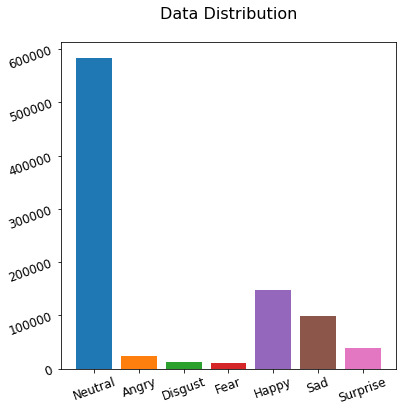

Number of images:	319348
Distribution:  {'Neutral': 182030, 'Angry': 7936, 'Disgust': 5807, 'Fear': 9734, 'Happy': 52508, 'Sad': 38270, 'Surprise': 23063}


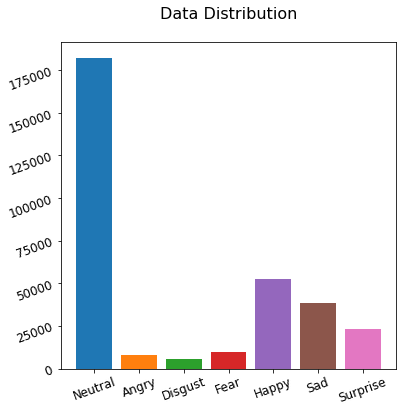

Number of images:	997326
Distribution:  {'Test': 997326}


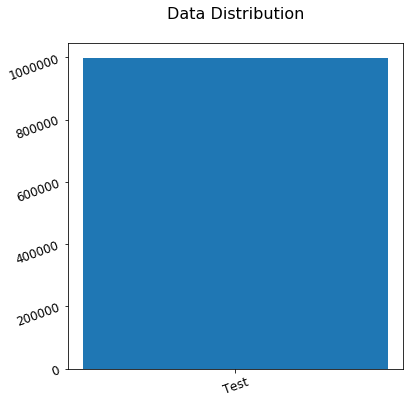

In [7]:
ds.view_emotion_summary(ds.a_idx_train, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_test, figsize=(6,6));

In [8]:
train_loader = ExprImageBalancedDataLoader(ds.a_idx_train, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

valid_loader = ExprImageBalancedDataLoader(ds.a_idx_valid, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_loader = ExprImageBalancedDataLoader(ds.a_idx_test, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

(224, 3) (224, 3) (7,)
(224, 3) (224, 3) (7,)
(224, 3) (224, 3) None
Training


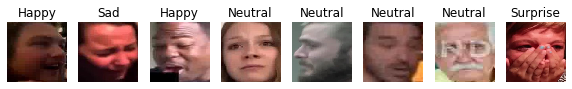

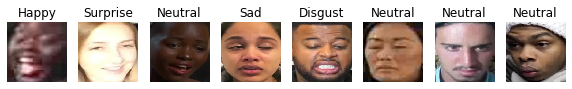

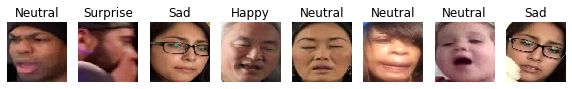

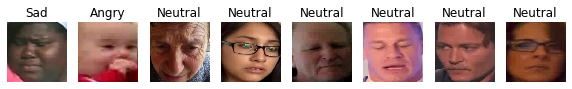

Validating


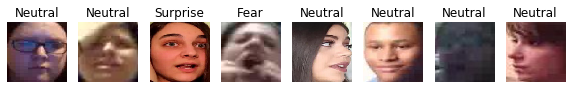

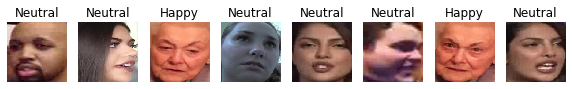

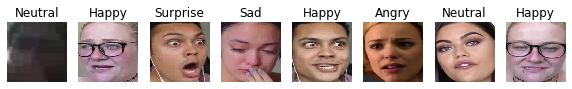

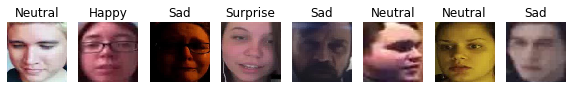

Testing


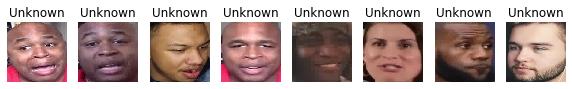

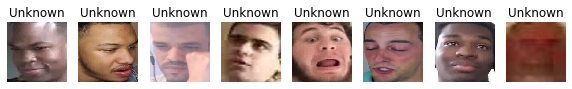

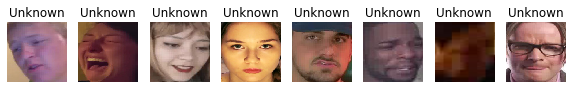

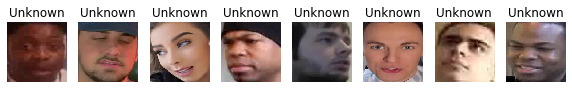

In [9]:
x, y = train_loader[20]
print(x[0].shape, x[1].shape, y.shape)
x, y = valid_loader[20]
print(x[0].shape, x[1].shape, y.shape)
x, y = test_loader[20]
print(x[0].shape, x[1].shape, y)

print("Training")
train_loader.view_images()
print("Validating")
valid_loader.view_images()
print("Testing")
test_loader.view_images()

In [10]:
train_gen = DataGenerator(dataloader = train_loader, 
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Train: ")
x, y = next(train_gen)
print(x.shape, np.min(x), np.max(x))
print(y.shape)

valid_gen = DataGenerator(dataloader = valid_loader, 
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Valid: ")
x, y = next(valid_gen)
print(x.shape, np.min(x), np.max(x))
print(y.shape)

test_gen = DataGenerator(dataloader = test_loader, 
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test: ")
x, y = next(test_gen)
print(x.shape, np.min(x), np.max(x))
print(y)

Train: 
(256, 224, 224, 3) -131.0912 163.5047
(256, 7)
Valid: 
(256, 224, 224, 3) -131.0912 92.5047
(256, 7)
Test: 
(256, 224, 224, 3) -119.0912 144.11731
None


## 3. Setup Model

In [11]:
if params["run_train"]==True or params["run_valid"]==True or params["run_test"]==True:
    # Load Model
    K.clear_session()
    model = load_model(params["weights_path"], custom_objects={"loss_ccc": loss_ccc, 
                                                               "ccc": ccc, 
                                                               "f1_score": f1_score, 
                                                               "expr_score": expr_score})
    # Model Summary
    model.summary()
    
    if params["use_parallel_model"] == True:
        model = multi_gpu_model(model, gpus = len(params["gpus"]))
    # if
# if

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
________

## 4. Predict

### 4.1. Train

In [12]:
if params["run_train"] == True:
    train_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(train_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    else:
        y_pred = model.predict(train_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    # if
# if

3577/3577 [==============================] - 1042s 291ms/step


In [13]:
if params["run_train"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"train.npz")
    print(f"Save Train: {save_path}")
    np.savez(save_path, **y_results)
# if

Save Train: /mnt/dntai/projects/emotion/AffWild2Prj/submit/results/t24/train.npz


### 4.2. Valid

In [14]:
if params["run_valid"] == True:
    valid_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(valid_gen, steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(valid_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

1248/1248 [==============================] - 368s 295ms/step


In [15]:
if params["run_valid"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"valid.npz")
    print(f"Save Valid: {save_path}")
    np.savez(save_path, **y_results)
# if

Save Valid: /mnt/dntai/projects/emotion/AffWild2Prj/submit/results/t24/valid.npz


### 4.3. Test

In [16]:
if params["run_test"] == True:    
    test_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_gen, 
                               steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(test_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
# if

3896/3896 [==============================] - 1130s 290ms/step


In [17]:
if params["run_test"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred

    save_path = os.path.join(params["results_dir"], f"test.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

Save Test: /mnt/dntai/projects/emotion/AffWild2Prj/submit/results/t24/test.npz


## 5. Evaluation

### 5.1. Train

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.95      0.64      0.77    583474
       Angry       0.47      0.75      0.58     23702
     Disgust       0.42      0.83      0.56     12588
        Fear       0.42      0.63      0.51     11155
       Happy       0.44      0.79      0.56    147261
         Sad       0.73      0.92      0.81     98504
    Surprise       0.45      0.60      0.51     38858

    accuracy                           0.70    915542
   macro avg       0.55      0.74      0.61    915542
weighted avg       0.80      0.70      0.72    915542

Confustion Matrix Int: 
 [[375664  13202   9762   5574 134654  26604  18014]
 [  1653  17834    606    208   1523    875   1003]
 [   309    559  10456    189    645    208    222]
 [   809    336    138   7032    772   1358    710]
 [ 11296   4071   3066   1512 116297   3155   7864]
 [  2390    316    210   1030   3742  90266    550]
 [  3960   1594    853   1010   6898   12

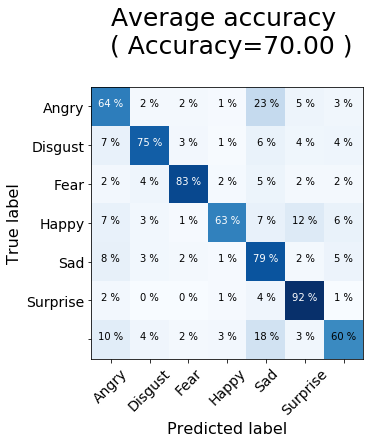

In [18]:
if params["val_train"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"train.npz")
    a_idx_data = ds.a_idx_train

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
# if

## 5.2. Valid

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.80      0.51      0.62    182030
       Angry       0.11      0.22      0.15      7936
     Disgust       0.07      0.07      0.07      5807
        Fear       0.07      0.07      0.07      9734
       Happy       0.37      0.78      0.50     52508
         Sad       0.44      0.47      0.45     38270
    Surprise       0.42      0.41      0.42     23063

    accuracy                           0.51    319348
   macro avg       0.33      0.36      0.33    319348
weighted avg       0.61      0.51      0.53    319348

Confustion Matrix Int: 
 [[93071 10456  2119  6295 52895  8760  8434]
 [ 1322  1709    75    23  2079  2564   164]
 [  397   146   402     3   755  3918   186]
 [ 2817   573   458   672   630  3287  1297]
 [ 4755   674   544   491 40769  3707  1568]
 [ 9247   862  1417  1453  5674 18079  1538]
 [ 4660   788   347   314  6528   895  9531]]

Confustion Matrix Norm: 
 [[5.11e+01

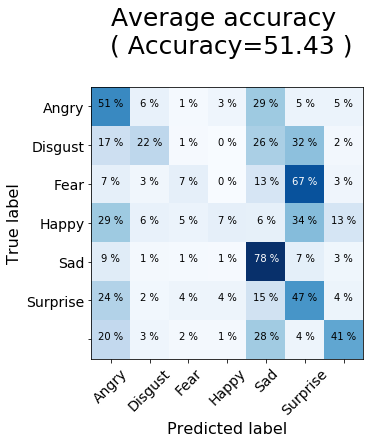

In [19]:
if params["val_valid"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"valid.npz")
    a_idx_data = ds.a_idx_valid

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
# if